In [1]:
from pymongo import MongoClient
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [2]:
MONGO_HOST= 'mongodb://localhost/twitter'
client = MongoClient(MONGO_HOST)
tweet_data = client.twitter.collections.tweets.find()

In [3]:
tweet_data = pd.DataFrame(list(tweet_data))

In [4]:
tweet_data.head(2)

,_id,created_at,favorites,followers,hashtags,id,retweets,text,user_favorites_count,username
0,5ba10b53f30ccd182428462d,Tue Sep 18 13:29:45 +0000 2018,0,940,[],1042042998236868611,0,Sheba Entertainment launches Artiste X-ray Art...,50,chaseymania
1,5ba10b53f30ccd182428462e,Tue Sep 18 13:29:46 +0000 2018,0,771,[],1042043002066104320,0,@Erophunk909 Artificial intelligence that gene...,4149,bach_chas


In [5]:
tweet_data['followers'].describe()

count      1000.00000
mean       9281.10300
std       39443.28754
min           0.00000
25%         172.00000
50%         867.00000
75%        4632.25000
max      525364.00000
Name: followers, dtype: float64

In [6]:
tweet_data['created_at'].describe()

count                               1000
unique                               823
top       Tue Sep 18 14:00:01 +0000 2018
freq                                   7
Name: created_at, dtype: object

In [22]:
# extract only the words and edit them for word frequency
tweets_text = " ".join(line.strip() for line in tweet_data['text'])  
tweets_text = re.sub("\W", ' ', tweets_text)
stop = stopwords.words('english')
newStopWords = ['https', 'how', 'big', 'co', 'via', 'the', 'I', 'will', 'amp', 'a', 'you', 'we']
stop.extend(newStopWords)

tokens = [word.lower() for word in tweets_text.split( )]
tokens = [words for words in tokens if words not in stop]


In [23]:
common_words = Counter(tokens).most_common(40)

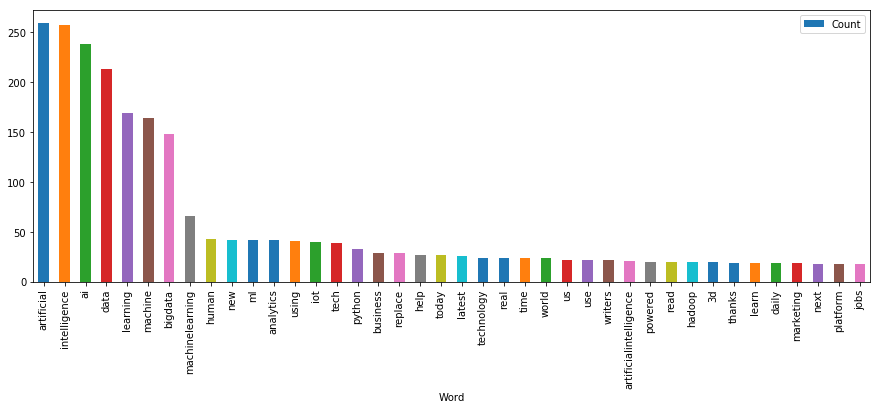

In [24]:
common_words_df = pd.DataFrame(common_words, columns = ['Word', 'Count'])
common_words_df.plot.bar(x='Word',y='Count', figsize=(15,5))

In [52]:
tweet_tokens = []
def preprocessing(text):
    tokens = [word.lower() for word in text.split( )]
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    # lower capitalization
    tokens = [word.lower() for word in tokens]
    # get rid of @name and #s
    tokens = [re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","", word) for word in tokens]
    tokens = [re.sub("http\S+", "", word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    tweet_tokens.append(preprocessed_text)

In [53]:
tweets = tweet_data['text']
for tweet in tweets:
    preprocessing(tweet)

In [54]:
tweet_counts = []
for tweet in tweet_tokens:
    count = {}
    for word in tweet.split(' '):
        if word not in count:
            count[word] = 1
        else:
            count[word] += 1
    tweet_counts.append(count)

tweet_counts[1]

{'': 1,
 'artificial': 1,
 'intelligence': 1,
 'generates': 1,
 'human': 1,
 'language': 1,
 'sounds': 1}

In [56]:
mini_corpus = pd.DataFrame(tweet_counts)

In [59]:
mini_corpus = mini_corpus.fillna(0)
mini_corpus.head(2)

,,0,0344pm,0355pm,0416pm,0426pm,05,1,10,100,...,youre,yours,youve,yuk,zcash,zeppelin,zillow,zimbabwe,ziontechgroup,zumper
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Latent Dirichlet Allocation code
N_TOPICS = 2
lda = LatentDirichletAllocation(n_components=N_TOPICS, learning_method='online')
lda.fit(mini_corpus)

topics = pd.DataFrame(lda.components_, columns=mini_corpus.columns)
topics = topics.transpose()

def get_top_words(topic, i):
    t = topic.sort_values(ascending=False).head(15)
    t = pd.DataFrame({f'word_{i}': t.index})
    t['num'] = range(15)
    t.set_index('num', inplace=True)
    return t

c = [get_top_words(topics[i], i) for i in range(N_TOPICS)]
result = pd.concat(c, axis=1)
print(result)

           word_0           word_1
num                               
0                                 
1      artificial               ai
2    intelligence         learning
3            data          bigdata
4              ai          machine
5             big             data
6           human              big
7             via  machinelearning
8         replace        analytics
9             new               ml
10           tech              iot
11         python              amp
12        writers              via
13             us           latest
14     technology             real
